In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.pseudotime_common import do_pca_pt, spearman_rho_pools
from jtb_2022_code import FigureSingleCellData

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import spearmanr

In [3]:
## LOAD AND PROCESS UMAP FOR UMAP PANELS ###
data = FigureSingleCellData()
data.do_projections()
data.apply_inplace_to_everything(do_pca_pt)

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad
Applying do_pca_pt to data [['1' '2'], ['WT' 'fpr1']] (173347, 5747)
Applying do_pca_pt to data [['1'], ['WT']] (63533, 5747)
Applying do_pca_pt to data [['1'], ['fpr1']] (4933, 5747)
Applying do_pca_pt to data [['2'], ['WT']] (98996, 5747)
Applying do_pca_pt to data [['2'], ['fpr1']] (5885, 5747)


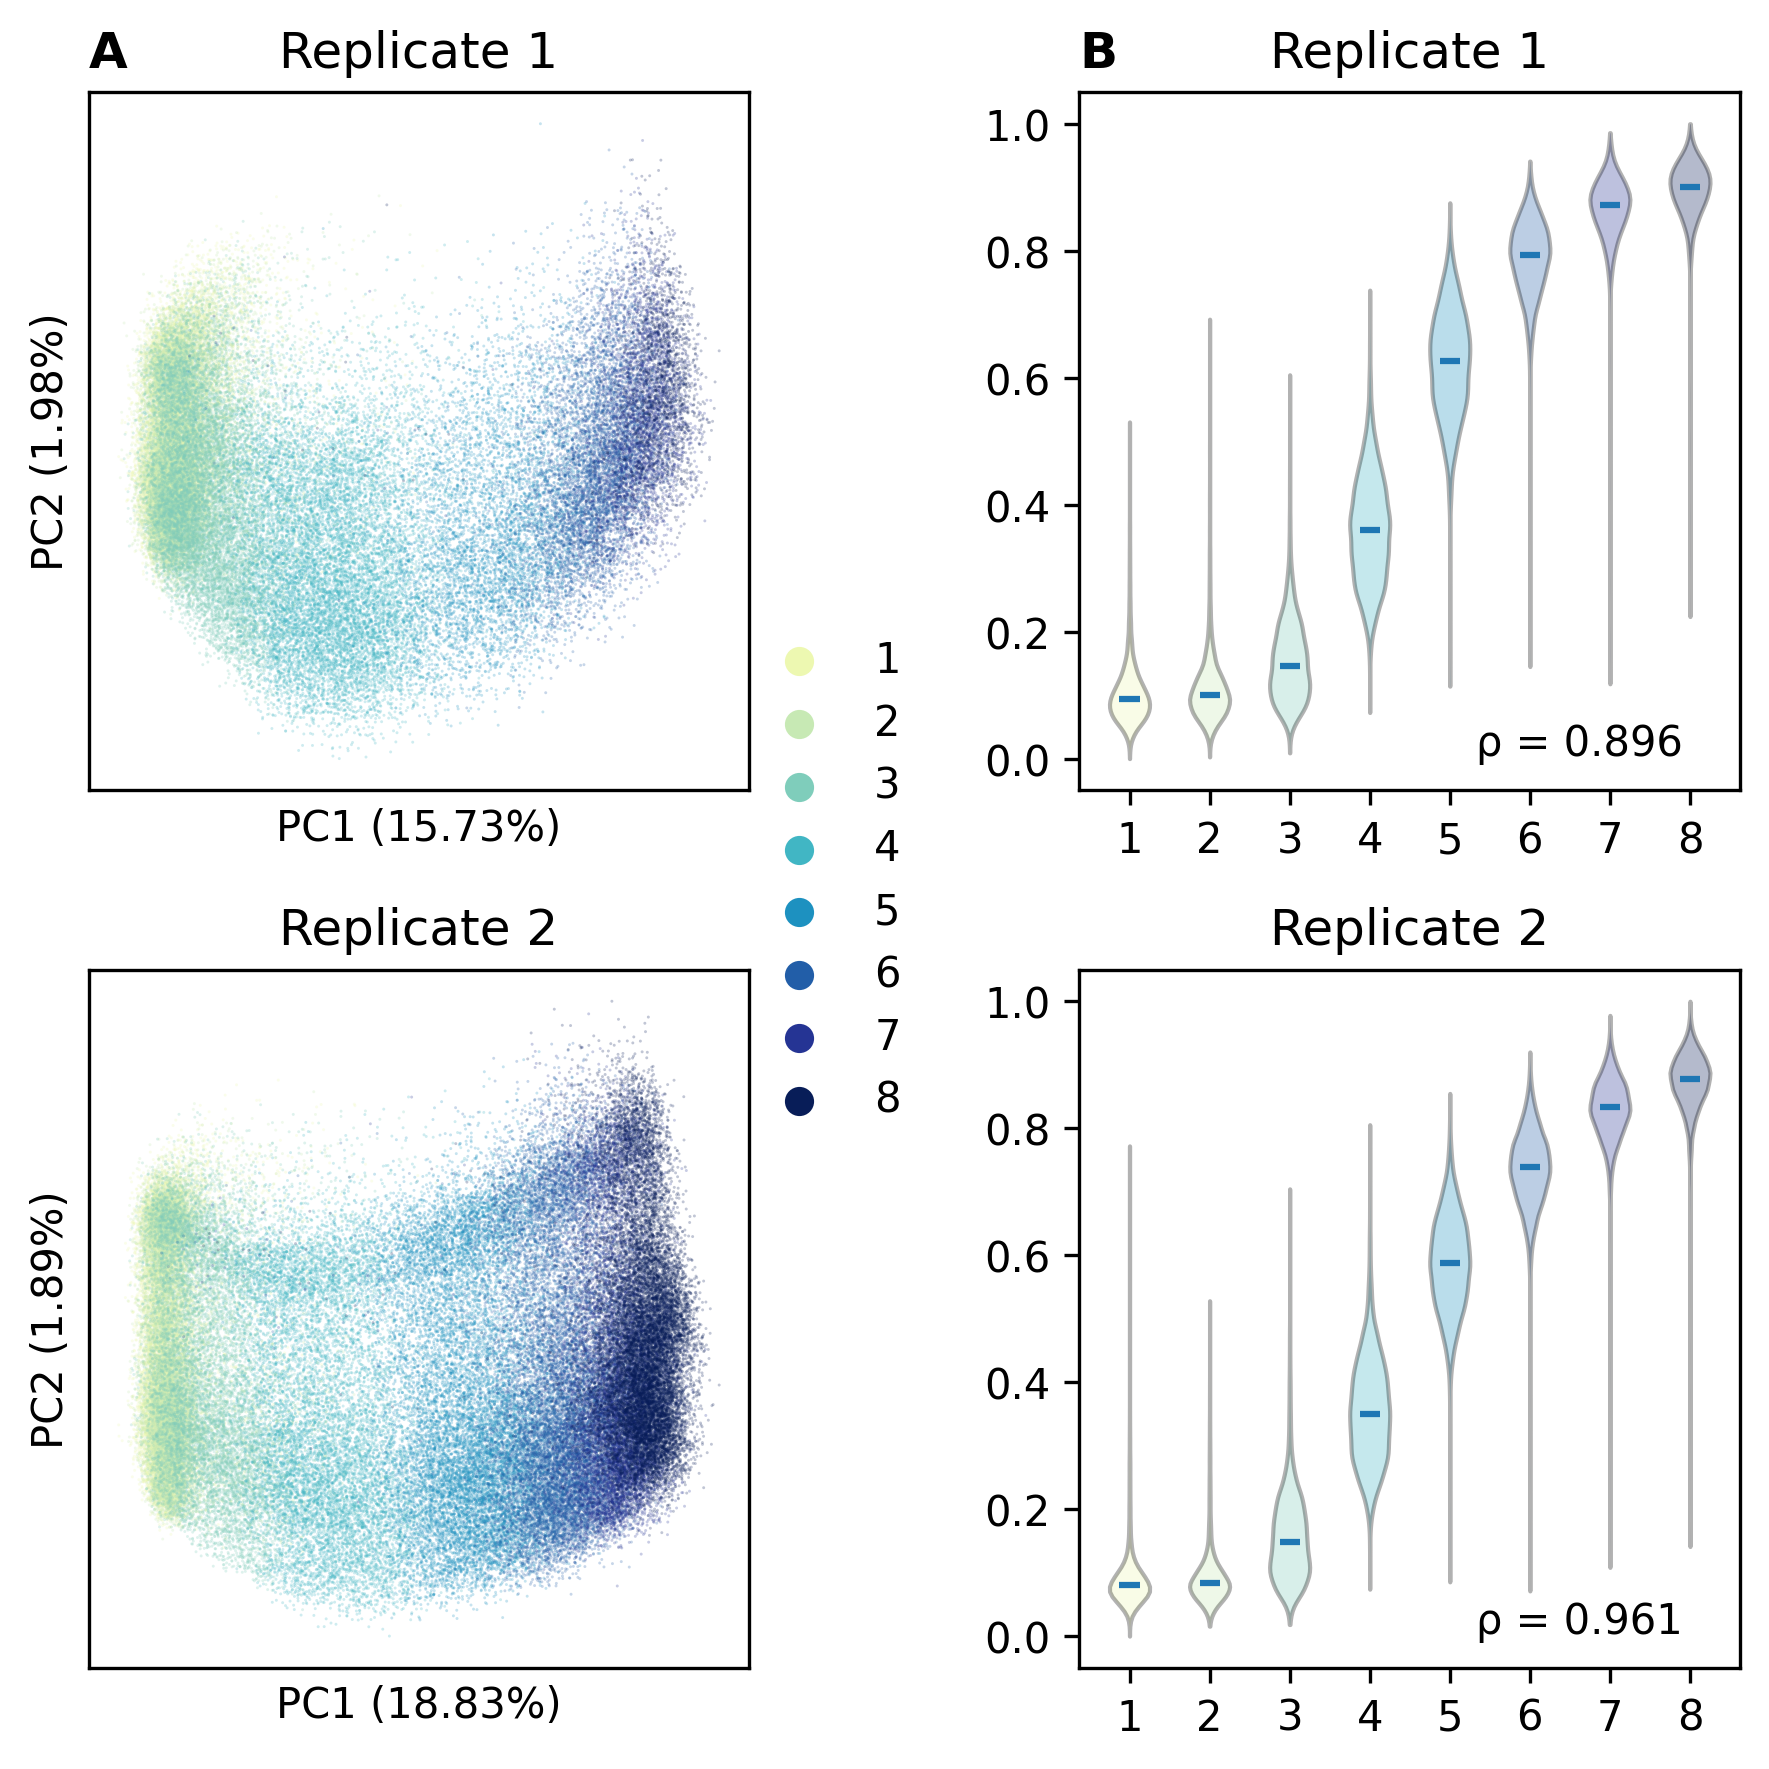

In [4]:
panel_labels = {'pca_1': "A",
                'pca_2': "",
                'pca_pt_1': "B",
                'pca_pt_2': ""}

panel_titles = {'pca_1': "Replicate 1",
                'pca_2': "Replicate 2",
                'pca_pt_1': "Replicate 1",
                'pca_pt_2': "Replicate 2"}

fig_refs = {}

fig, axd = plt.subplot_mosaic([['pca_1', 'pca_lgd', 'pca_pt_1'],
                               ['pca_2', 'pca_lgd', 'pca_pt_2']],
                              gridspec_kw=dict(width_ratios=[1, 0.5, 1], 
                                               height_ratios=[1, 1],
                                               wspace=0), 
                              figsize=(6, 6), dpi=300)
                              #constrained_layout=True)
plt.subplots_adjust(wspace=0)

axd["pca_lgd"].axis('off')
    
for i in range(1,3):
    pca_key = "pca_" + str(i)
    pt_key = "pca_pt_" + str(i)
    
    pca_data = data.expt_data[i, "WT"]

    ### PANEL A ###
    fig_refs[pca_key] = sc.pl.pca(pca_data, ax=axd[pca_key], 
                                  color="Pool", palette=pool_palette(), 
                                  show=False, alpha=0.25, size=2, legend_loc='none',
                                  annotate_var_explained=True)

    ### PANEL B ###
    pca_pt_data = {k: v['pca_pt'] for k, v in pca_data.obs[['pca_pt', 'Pool']].groupby("Pool")}
    fig_refs[pt_key] = axd[pt_key].violinplot([pca_pt_data[j] for j in range(1,9)], 
                                              showmeans=False, showmedians=True, showextrema=False)
    axd[pt_key].set_xticks(np.arange(8) + 1, labels=np.arange(8) + 1)
    
    rho = spearman_rho_pools(pca_data.obs['Pool'], pca_data.obs['pca_pt'])
    axd[pt_key].annotate("ρ = " + f"{rho:.3f}", xy=(5, 0.2),  xycoords='data', xytext=(0.6, 0.05), textcoords='axes fraction')
    
    for part, c in zip(fig_refs[pt_key]['bodies'], pool_palette()):
        part.set_facecolor(c)
        part.set_edgecolor('black')

fig_refs['pca_legend'] = add_legend(axd['pca_lgd'], 
                                    pool_palette(), 
                                    data.all_data.obs['Pool'].dtype.categories.values)

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(panel_titles[ax_id])
    axd[ax_id].set_title(label, loc='left', weight='bold')
    
fig.tight_layout()   